# Krigging

In [1]:
from all_imports import *

import _modules

%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

from pykrige.rk import RegressionKriging
import datetime as dt

 ### test init### 


## Weather Data Analysis

In [ ]:
#Combine all Weather files
def LoadWeatherStationDataIntoDf(item: str, dirs: List[str] = []) -> pd.DataFrame:

    #get all unique files
    #add them together first individually
    #then concat all of them

    df_list = []
    for file_dir in dirs:
        filepaths, filenames = _modules.find_files_in_directory(file_dir, 'csv')
        
        for weather_file in filepaths:
            #print(weather_file)
            filename = os.path.basename(weather_file)
            station_name = filename.split('_')[1]
            df = pd.read_csv(weather_file)
            df = df[['Datetime', item]]
            df.rename(columns={item: f"{station_name}_{item}"}, inplace=True)

            df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%dT%H:%M:%S')
            df = df.drop_duplicates('Datetime') #Sure?
            df.set_index('Datetime', inplace=True)
            
            df_list.append(df)

    combined_df = pd.concat(df_list, axis=1, join='outer')
    combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
    return combined_df


dirs = [r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202402\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202403\EveryMinute']

WS_Temp_df = LoadWeatherStationDataIntoDf('AirTemp Ave (C)', dirs)
WS_relH_df = LoadWeatherStationDataIntoDf('AirTemp Ave (C)', dirs)
# display(WS_Temp_df)
# pprint(WS_Temp_df.columns)

start_date = '2024-02-20'
end_date = '2024-03-15'
WS_Temp_filtered_df = WS_Temp_df.loc[start_date:end_date]

display(WS_Temp_filtered_df.columns)


In [2]:
# Minutly Weather data plot for the selected timeframe
from pyproj import Proj, transform

#Define for each weathr station the features based on the gridcells, get for now onlz the closest ones.
parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirOut: str = r'Esse\report\krigging_output'

# File Definitions
griddf = pd.read_csv(parent_dir + '5mGrid_features_original.csv').fillna(0)


# Creating DataFrame
WS_df = pd.read_csv(os.path.join(parent_dir, 'WS_features_updated.csv'))
wgs84 = Proj(init='epsg:4326')  # WGS84 coordinate system (standard for lat/lon)
utm = Proj(init='epsg:3414')   # UTM Zone 48N for Singapore

# Function to convert SVY21 coordinates to latitude and longitude (for verification)
def convert_to_meters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

# Apply the conversion to SVY21 coordinates to meters
WS_df['X'], WS_df['Y'] = convert_to_meters(WS_df['Lon'], WS_df['Lat'])

# ----------------------------------------
#TODO ADJUST THIS PLOT LATER FOR PRESENTATION
# fig = px.scatter_mapbox(
#     WS_df,
#     lat='Lat',
#     lon='Lon',
#     title='Weather Station Locations in Singapore',
#     opacity=0.7,  # Adjust opacity of markers
#     zoom=12,  # Adjust the initial zoom level for a closer view
#     center={"lat": 1.3521, "lon": 103.8198},  # Center map on Singapore's approximate coordinates
# )

# # Update layout with Mapbox style and centering options
# fig.update_layout(
#     mapbox_style="carto-positron",  # Set the style to "carto-positron" for grey map
#     margin={"r":0,"t":40,"l":0,"b":0},  # Adjust margins for better layout
#     height=900,  # Increase the height of the plot
# )

# # Show the plot
# fig.show()
# ----------------------------------------
#WS_Temp_filtered_df['WS03_AirTemp Ave (C)'].plot(figsize=(14, 6))
# ----------------------------------------

display(griddf)

c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\gottk\AppData\Local\Temp\ipykernel_32952\3655650510.py:19: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/got

,Unnamed: 0,X,Y,id,distToTree,distToCarpark,distToCourtTrack,distToPath,distToRoad,distToWalkway,distToBuilding,Sun_h,Bld_SkyEx,Veg_SkyEx,Veg_height,Veg_percent,Bld_percent,Bld_height,Ter_height
0,0,22187.5,30692.5,77604,0.000000,63.307985,126.195950,7.390848,25.440924,23.503916,11.635957,9,63.078176,66.049332,49.424421,0.000000,0.000000,0.000000,49.424421
1,1,22187.5,30687.5,77605,0.000000,68.014909,124.831602,12.087238,21.686119,19.737900,16.420043,9,64.015580,50.917968,49.628777,0.000000,85.062123,0.000000,49.628777
2,2,22197.5,30722.5,78180,55.263466,31.693100,146.781762,5.106590,54.906503,53.416358,0.000000,0,0.000000,75.245290,43.347381,5.203222,0.000000,63.791724,43.347381
3,3,22197.5,30717.5,78181,60.041791,36.400010,144.576612,4.768805,51.022771,49.227171,0.000000,0,0.000000,75.892621,43.828036,0.000000,0.000000,63.791724,43.828036
4,4,21632.5,30382.5,45365,23.579758,65.397386,287.481258,171.065282,3.948153,53.468093,0.000000,0,0.000000,62.211868,15.752680,0.000000,0.000000,36.428059,15.752680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56175,56175,22427.5,30452.5,91620,54.094083,111.624158,243.602350,116.723498,2.290531,0.790519,29.217055,10,75.183959,0.000000,45.294563,0.000000,50.071585,0.000000,45.294563
56176,56176,22427.5,30447.5,91621,50.504236,114.951070,240.452998,119.067464,6.069861,4.569858,26.109542,10,74.521210,0.000000,44.373172,0.000000,17.031179,0.000000,44.373172
56177,56177,22427.5,30442.5,91622,47.171875,118.395712,237.367190,121.571983,9.849192,8.349197,23.643713,10,75.183959,0.000000,43.497971,0.000000,26.052403,0.000000,43.497971
56178,56178,22427.5,30437.5,91623,44.155337,121.948106,234.347439,124.227344,13.628522,12.128536,22.053167,10,77.247454,0.000000,42.621719,0.000000,53.265738,0.000000,42.621719


[1191, 1192, 1229, 8993, 8994, 9032, 9033, 9069, 10509, 10510, 10536, 10537, 10563, 10610, 10611, 10637, 10638, 10665, 11459, 11470, 11471, 11483, 11484, 11619, 11620, 11627, 11628, 12914, 19006, 19007, 19008, 19121, 19122, 20097, 20133, 20194, 20195, 20230, 20231, 20292, 20293, 20328, 20329, 21708, 21777, 21778, 21779, 21846, 22115, 22116, 22181, 22182, 22252, 23135, 23184, 23185, 23186, 23236, 26304, 26343, 26344, 26382, 26383, 27091, 27092, 27142, 27143, 27194, 27386, 27450, 27451, 27528, 27529, 28569, 28570, 28571, 28659, 28660, 28813, 28814, 28815, 28905, 28906, 29381, 29473, 29474, 29475, 29565, 30229, 30230, 30295, 30296, 30297, 32835, 32938, 32939, 32940, 33044, 33234, 33344, 33345, 33346, 33457, 33575, 33690, 33691, 33692, 33715, 33716, 33808, 33817, 33818, 33819, 33831, 33832, 33833, 33934, 33935, 34384, 34385, 34498, 34499, 34613, 34923, 34924, 35034, 35035, 35036, 37807, 38357, 38358, 38401, 38402, 38433, 38434, 38477, 38478, 38479, 38508, 39059, 39060, 39100, 39101, 39138,

,Number/file name in AWS,Reflected in Google Map to NUS President,Type,Longname,Shortname,Lon,Lat,X,Y
0,76,1,Weather station,Lamp post - CP2A in front E3A,WS76,103.771232,1.300666,21090.276586,31446.608220
1,60,2,Weather station,Roof - E1A upper roof,WS60,103.770585,1.299491,21018.301427,31316.750821
2,62,3,Weather station,Lamp post - in between E2-E1A,WS62,103.771021,1.299327,21066.835035,31298.582162
3,3,4,Weather station,Railing - E1 level 2,WS3,103.770776,1.298865,21039.589703,31247.486168
4,75,5,Weather station,Railing - next to EW1,WS75,103.770744,1.298231,21036.026652,31177.437049
5,73,6,Weather station,Roof - SDE3,WS73,103.770400,1.298318,20997.720468,31187.013787
6,61,7,Weather station,Column - shelter next to E8,WS61,103.772722,1.299241,21256.096493,31289.079173
7,29,8,Weather station,Lamp post - U-Turn in front of LKCNH Museum,WS29,103.773258,1.301106,21315.797958,31495.288895
8,25,9,Weather station,Lamp post - roundabout YIH,WS25,103.774591,1.299708,21464.100803,31340.679569
9,11,10,Weather station,Lamp post - bus stop NUS IT,WS11,103.772713,1.297254,21255.134122,31069.355797


,Unnamed: 0,X,Y,id,distToTree,distToCarpark,distToCourtTrack,distToPath,distToRoad,distToWalkway,...,Sun_h,Bld_SkyEx,Veg_SkyEx,Veg_height,Veg_percent,Bld_percent,Bld_height,Ter_height,Lon,Lat
0,0,22187.5,30692.5,77604,0.000000,63.307985,126.195950,7.390848,25.440924,23.503916,...,9,63.078176,66.049332,49.424421,0.000000,0.000000,0.000000,49.424421,103.781091,1.293846
1,1,22187.5,30687.5,77605,0.000000,68.014909,124.831602,12.087238,21.686119,19.737900,...,9,64.015580,50.917968,49.628777,0.000000,85.062123,0.000000,49.628777,103.781091,1.293801
2,2,22197.5,30722.5,78180,55.263466,31.693100,146.781762,5.106590,54.906503,53.416358,...,0,0.000000,75.245290,43.347381,5.203222,0.000000,63.791724,43.347381,103.781181,1.294117
3,3,22197.5,30717.5,78181,60.041791,36.400010,144.576612,4.768805,51.022771,49.227171,...,0,0.000000,75.892621,43.828036,0.000000,0.000000,63.791724,43.828036,103.781181,1.294072
4,4,21632.5,30382.5,45365,23.579758,65.397386,287.481258,171.065282,3.948153,53.468093,...,0,0.000000,62.211868,15.752680,0.000000,0.000000,36.428059,15.752680,103.776104,1.291042
5,5,21632.5,30377.5,45366,20.466606,70.386331,289.345835,174.238752,8.641411,58.467940,...,0,0.000000,60.809963,14.995228,0.000000,0.000000,40.746973,14.995228,103.776104,1.290997
6,6,21632.5,30372.5,45367,18.214252,75.375276,291.210412,177.496351,12.166510,63.467811,...,0,0.000000,62.804284,14.237775,0.000000,0.000000,40.746973,14.237775,103.776104,1.290952
7,7,21632.5,30367.5,45368,17.164964,80.364221,293.074988,180.833533,9.013204,68.467700,...,0,0.000000,55.698360,12.769169,0.000000,0.000000,36.428059,12.769169,103.776104,1.290907
8,8,21632.5,30362.5,45369,17.536048,85.353167,294.939565,184.245974,7.398909,73.467605,...,4,65.442794,46.905788,10.851430,0.000000,0.000000,0.000000,10.851430,103.776104,1.290862
9,9,21632.5,30357.5,45370,19.245518,90.342524,296.804194,187.729568,8.073170,78.467522,...,8,77.217573,40.759714,10.377552,0.000000,53.320913,0.000000,10.377552,103.776104,1.290816


C:\Users\gottk\AppData\Local\Temp\ipykernel_32952\4124952916.py:67: FutureWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



,Unnamed: 0,X,Y,id,distToTree,distToCarpark,distToCourtTrack,distToPath,distToRoad,distToWalkway,...,Sun_h,Bld_SkyEx,Veg_SkyEx,Veg_height,Veg_percent,Bld_percent,Bld_height,Ter_height,Lon,Lat
1191,1191,21627.5,30757.5,44999,0.000000,78.143103,362.257911,44.721991,33.740626,39.455182,...,0,0.000000,57.931314,34.642558,0.000000,0.000000,0.000000,34.642558,103.776059,1.294434
1192,1192,21627.5,30752.5,45000,0.000000,75.961340,358.748875,45.078426,29.746426,34.686790,...,0,0.000000,57.406778,33.120759,0.000000,0.000000,38.093745,33.120759,103.776059,1.294389
1229,1229,21632.5,30752.5,45291,0.000000,80.446356,362.344864,40.122383,33.169381,36.598352,...,5,41.161520,46.207700,35.197958,0.000000,0.000000,0.000000,35.197958,103.776104,1.294389
8993,8993,22162.5,30427.5,76202,19.428015,106.078181,131.535775,19.922533,28.001688,26.456581,...,4,25.488223,68.297430,37.809824,97.745530,0.000000,0.000000,37.809824,103.780866,1.291449
8994,8994,22162.5,30422.5,76203,14.847618,109.794588,126.535783,15.294192,23.523334,21.971930,...,0,0.000000,62.919778,36.481240,29.383595,0.219903,49.041783,36.481240,103.780866,1.291404
9032,9032,22167.5,30427.5,76493,16.436496,102.740949,131.526817,18.398183,29.998861,28.538983,...,5,31.836025,74.491125,38.965394,100.000000,0.000000,0.000000,38.965394,103.780911,1.291449
9033,9033,22167.5,30422.5,76494,17.704202,106.573794,126.526825,13.891303,25.222622,23.647815,...,4,22.082512,66.941641,37.705060,96.751030,0.000000,0.000000,37.705060,103.780911,1.291404
9069,9069,22172.5,30427.5,76784,11.745569,99.543079,131.517858,14.925403,31.099992,29.549912,...,3,31.650807,73.813300,39.802101,55.957424,0.000000,0.000000,39.802101,103.780956,1.291449
10509,10509,22157.5,30382.5,75920,24.163253,144.982404,86.544806,25.907084,1.198661,10.461993,...,9,48.536982,0.000000,28.786161,0.000000,6.907190,21.605303,28.786161,103.780821,1.291043
10510,10510,22157.5,30377.5,75921,27.826512,149.238630,81.544814,30.275485,0.000000,13.763041,...,8,43.088518,68.236990,28.114000,0.000000,0.000000,21.605303,28.114000,103.780821,1.290997


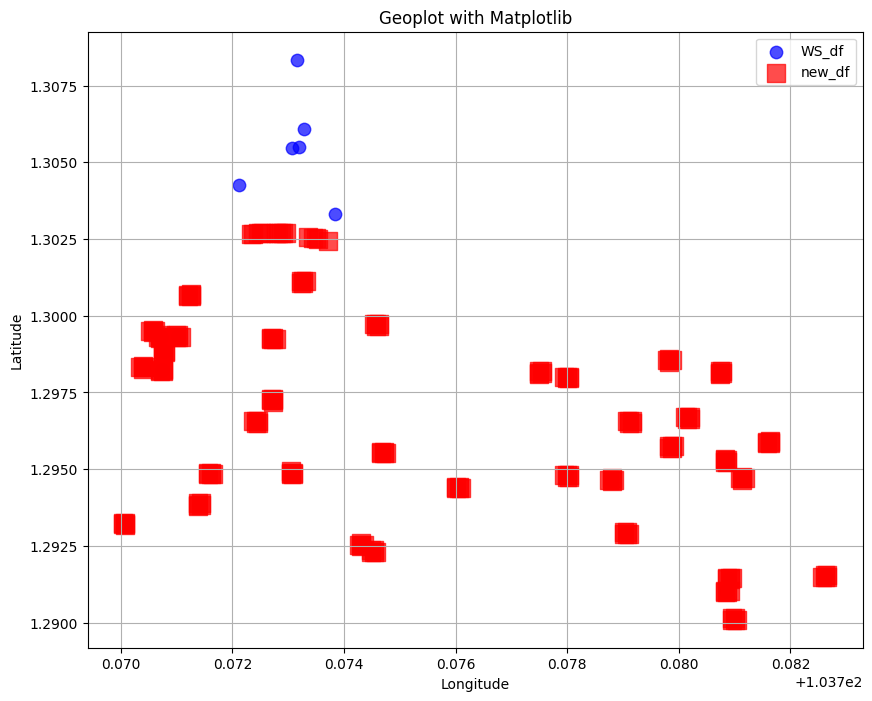

In [9]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import plotly.graph_objects as go

# Function to find closest grid cell and merge data
def add_closest_grid_info(WS_df, griddf, columns=['distToTree', 'distToCarpark']):
    # Calculate distances
    distances = cdist(WS_df[['X', 'Y']], griddf[['X', 'Y']])
    
    # Find index of closest grid cell for each point in WS_df
    closest_indices = np.argmin(distances, axis=1)
    
    # Create a DataFrame with closest grid cell information
    closest_info = griddf.iloc[closest_indices][columns].reset_index(drop=True)
    
    # Add reference column to closest_info
    closest_info['reference'] = closest_indices
    
    # Concatenate closest_info with WS_df
    WS_df = pd.concat([WS_df.reset_index(drop=True), closest_info], axis=1)
    
    # Return the modified WS_df and list of reference values
    return WS_df, closest_indices.tolist()

def add_closest_grid_info_multiple(WS_df, griddf, columns=['distToTree', 'distToCarpark'], num_closest=5):
    # Calculate distances
    distances = cdist(WS_df[['X', 'Y']], griddf[['X', 'Y']])
    
    # Find indices of the num_closest grid cells for each point in WS_df
    closest_indices = np.argsort(distances, axis=1)[:, :num_closest]
    
    # Initialize lists to store averaged column values
    averaged_values = {col: [] for col in columns}
    
    # Compute the average of the specified columns for the closest grid cells
    for indices in closest_indices:
        closest_data = griddf.iloc[indices][columns]
        for col in columns:
            averaged_values[col].append(closest_data[col].mean())
    
    # Create a DataFrame with the averaged information
    averaged_info = pd.DataFrame(averaged_values)
    
    # Concatenate averaged_info with WS_df
    WS_df = pd.concat([WS_df.reset_index(drop=True), averaged_info], axis=1)
    
    # Collect all unique reference values
    unique_reference_values = np.unique(closest_indices.flatten()).tolist()
    
    # Return the modified WS_df and list of unique reference values
    return WS_df, unique_reference_values

# Add closest grid cell information to WS_df
# modified_WS_df, reference_values = add_closest_grid_info(WS_df, griddf, columns=['distToTree', 'distToCarpark'])
modified_WS_df, reference_values = add_closest_grid_info_multiple(WS_df, griddf, columns=['distToTree', 'distToCarpark'], num_closest=5)

print(reference_values)

display(WS_df.head(10))
display(griddf.head(10))

# Select rows from griddf based on indices using loc
selected_rows = griddf.loc[reference_values]
new_df = pd.DataFrame(selected_rows)
def convert_to_lon_lat(x, y):
    lon, lat = transform(utm, wgs84, x, y)
    return lon, lat


new_df['Lon'], new_df['Lat'] = convert_to_lon_lat(new_df['X'], new_df['Y'])

griddf['Lon'], griddf['Lat'] = convert_to_lon_lat(griddf['X'], griddf['Y'])

display(new_df.head(10))
#Visualize it

#TODO ADJUST THIS PLOT LATER FOR PRESENTATION
# Concatenate WS_df and new_df

# Add WS_df markers in blue (smaller)
# Create figure object
fig = go.Figure()

# Add WS_df markers in blue
fig.add_trace(
    go.Scattermapbox(
        lat=WS_df['Lat'],
        lon=WS_df['Lon'],
        mode='markers',
        marker=dict(
            size=8,
            color='blue',
            opacity=0.7
        ),
        name='WS_df'
    )
)

# Add new_df markers in red (larger) with square symbol
fig.add_trace(
    go.Scattermapbox(
        lat=griddf['Lat'],
        lon=griddf['Lon'],
        mode='markers',
        marker=dict(
            size=8,
            color='grey',
            opacity=0.7
        ),
        name='grid_df'
    )
)

# Highlight specified indices in red
fig.add_trace(
    go.Scattermapbox(
        lat=griddf.loc[reference_values, 'Lat'],
        lon=griddf.loc[reference_values, 'Lon'],
        mode='markers',
        marker=dict(
            size=12,
            symbol='circle',  # You can change the symbol if needed
            color='red',
            opacity=0.7,
        ),
        name='highlighted_points'
    )
)

# Update layout with Mapbox style and centering options
fig.update_layout(
    mapbox_style="carto-positron",  # Set the style to "carto-positron" for grey map
    margin={"r":0,"t":40,"l":0,"b":0},  # Adjust margins for better layout
    height=600  # Set the height of the plot
)

# Show the plot
fig.show()
#--------------------------------------------------------------


In [ ]:
display(combined_df)

In [ ]:

# Create the scatter mapbox plot
fig = px.scatter_mapbox(
    WS_df,
    lat='Lat',
    lon='Lon',
    title='Weather Station Locations in Singapore',
    opacity=0.7,
    zoom=12,
    center={"lat": 1.3521, "lon": 103.8198},
)

# Plot reference grid cells
fig.add_trace(
    px.scatter_mapbox(
        griddf.loc[WS_df['reference']],
        lat='Lat',
        lon='Lon',
        hover_name=griddf.index.astype(str),  # Use grid cell indices as hover labels
        text=['Reference Grid Cell {}'.format(i) for i in WS_df['reference']],
        opacity=0.9,
    ).data[0]
)

# Update layout with Mapbox style and centering options
fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r": 0, "t": 40, "l": 0, "b": 0},
    height=900,
)

# Show the plot
fig.show()

What do i need?

A Boxplot for each weather station, average, time of the day (night and day) and a linechart for the temperature path during the study
-- > this for each weatherstation as a layout plot

plot per average minute values, mazbe cluster the differnte stations based on environment

In [ ]:
WS_Temp_df_days = WS_Temp_df.resample('D').mean()
WS_Temp_df_days[['WS03_AirTemp Ave (C)', 'WS09_AirTemp Ave (C)']].plot(kind='line', figsize=(14, 6))
WS_Temp_df_days.plot(kind='line', figsize=(14, 6))

In [ ]:
# Weather Analsis similar 
average_temp = WS_Temp_df_days.mean(axis=1)
min_temp = WS_Temp_df_days.min(axis=1)
max_temp = WS_Temp_df_days.max(axis=1)

# Plotting
plt.figure(figsize=(14, 6))

# Plot shaded area between min and max temperatures
plt.fill_between(WS_Temp_df_days.index, min_temp, max_temp, color='lightgrey', alpha=0.5)

# Plot average temperature as a red line
plt.plot(WS_Temp_df_days.index, average_temp, color='red', linewidth=2, label='Average Temperature')

# Set title and labels
plt.title('Average, Min, and Max Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.legend()

# Customize grid and ticks
plt.grid(True, linestyle='--', alpha=0.8)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
WS_Temp_df

In [ ]:
# Filter data for the specific date range
start_date = '2024-02-20'
end_date = '2024-03-15'
filtered_df = WS_Temp_df.loc[start_date:end_date]

# Resample the data to daily intervals
WS_Temp_df_daily = filtered_df.resample('D').mean()

# Reset index to have 'Datetime' as a column for easier manipulation
WS_Temp_df_daily.reset_index(inplace=True)

# Melt the dataframe to long format for seaborn
WS_Temp_long = WS_Temp_df_daily.melt(id_vars=['Datetime'], var_name='Station', value_name='Temperature')

# Extract day from Datetime for plotting
WS_Temp_long['Day'] = WS_Temp_long['Datetime'].dt.date

# Plot the data
plt.figure(figsize=(15, 8))
sns.violinplot(x='Day', y='Temperature', data=WS_Temp_long, inner='box', color='red')
plt.xticks(rotation=90)
plt.title('Daily Temperature Distribution (20.02.2024 - 15.03.2024)')
plt.xlabel('Day')
plt.ylabel('Temperature (C)')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



df = sns.load_dataset("titanic")

sns.violinplot(data=df, x="class", y="age", hue="alive", split=True, gap=.1, inner="box")


In [ ]:
# Filter data by date range
start_date = '2024-02-20'
end_date = '2024-03-15'

WS_Temp_filtered = WS_Temp_df.loc[start_date:end_date]
WS_relH_filtered = WS_relH_df.loc[start_date:end_date]

# Melt the DataFrames to long format
WS_Temp_melted = WS_Temp_filtered.reset_index().melt(id_vars='Datetime', var_name='Station', value_name='AirTemp Ave (C)')

# Extract 'day' and 'night' based on Datetime (assuming day is 6am to 6pm)
WS_Temp_melted['Time of Day'] = WS_Temp_melted['Datetime'].apply(lambda x: 'day' if 6 <= x.hour < 18 else 'night')

# Plotting split violin plot for Temperature
plt.figure(figsize=(12, 8))
sns.violinplot(data=WS_Temp_melted, x='Station', y='AirTemp Ave (C)', hue='Time of Day', split=True, inner="quartile")
plt.title('Split Violin Plot for Temperature')
plt.xlabel('Station')
plt.ylabel('Air Temperature (°C)')
plt.legend(title='Time of Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Regression Kriging


In [ ]:
#TODO!
#analyse the weather station data
#How to do the krigign, check the gps data, what are the time differences


#Get the participant Data local and filter out the relevenat dates and times by 5min increments?
#Create a plot, how much time on average on runs between Locations points, this is the base fro the interpolation
#Combine all weather data into one df
#Take from the pool the relevant data and create the waetherdatafiles for the regression
#Analysie the temperatrue data in a linechart plot


# Directory Definitions
parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirWH: str = os.path.join(parent_dir, 'Weatherdata')
dirOut: str = r'Esse\report\krigging_output'

# File Definitions
griddf    = pd.read_csv(parent_dir + '5mGrid_features_original.csv').fillna(0)
wsdf      = pd.read_csv(parent_dir + 'WS_features.csv').fillna(0)

# plttitle = 'RegressionKriging'
today = dt.datetime.now().strftime("%m%d%y-%H%M")
print(today)


#Load Files and make a feature selection
#Feature selection
terrain_features  = ['Ter_height']
sky_features      = ['Sun_h', 'Bld_SkyEx', 'Veg_SkyEx']
bld_features      = ['Bld_percent', 'Bld_height']
veg_features      = ['Veg_height', 'Veg_percent']
distance_features = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad',  'distToPath', 'distToCourtTrack', 'distToCarpark']

features = distance_features + sky_features   + veg_features  + bld_features + terrain_features

display(griddf.head())
display(wsdf.head())
print(features)

### Get the Weather Data to interpolate
This loads the feature data.
Currently Available:


1. 'Tavg' Temperature
2. 'Radavg" Radiation (not yet)
3. 'Havg' Humidity (not yet)
4. 'Wsavg' Windspeed (not yet)
5. 'Wdavg' Winddirection (not yet)



In [ ]:
### Specify temperature measure to use
measure = "TAvg" # options: ['Tmax','Tavg']

### Read and prepare weather data
df = pd.read_csv(dirWH + '/' + measure +'.csv')
df = df.merge(wsdf[["X","Y",'ID']], on='ID', how='left')

### Get min and max value for plotting graph
minval = df.drop(columns=['ID','Lat','Long','X','Y']).min(numeric_only=True).min()
maxval = df.drop(columns=['ID','Lat','Long','X','Y']).max(numeric_only=True).max()
print("Min: ", minval, "Max: ",maxval)

display(df)

### Clustering

In [ ]:
metadatadf = griddf.copy()

# Quantization function
def quantize_column(column, step_size):
    return round(column / step_size) * step_size

# Number of steps for quantization
num_steps = 3

feature_list = ['Bld_percent', 'distToBuilding', 'Bld_height', 'Veg_height', 'distToTree']


# Determine step sizes for each column and apply quantization
for col in feature_list:
    step_size = metadatadf[col].max() / num_steps
    metadatadf[f'quantized_{col}'] = metadatadf[col].apply(quantize_column, args=(step_size,))

# Standard scaling
scaler = StandardScaler()
metadatadf[feature_list] = scaler.fit_transform(metadatadf[feature_list])

# KMeans clustering
n_clusters = 10
metadatadf['cluster'] = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(metadatadf[feature_list])

# Plot the clustered data
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='rainbow', s=1, marker='s')
plt.title('Clustered Data')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.colorbar(label='Cluster')
plt.show()
#-------------------------------------------------------------------------------------------------
# DBSCAN clustering
X = metadatadf[['cluster', 'X', 'Y']] #features for DBclustering
X_scaled = StandardScaler().fit_transform(X)

eps = 0.35
min_samples = 250
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
metadatadf['cluster'] = dbscan.fit_predict(X_scaled)

# Visualize the DBSCAN clustering
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='hsv', s=1, marker='s')
plt.colorbar(label='Cluster')
plt.title('DBSCAN Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#-------------------------------------------------------------------------------------------------
#downsampling and upscaling again
# Group by the cluster column
metadata_df_grp = metadatadf.groupby('cluster')

# Define a function to sample a specific percentage from each group
def downsample_group(group):
    return group.sample(frac=0.25)  # You can adjust the fraction as needed

# Apply the downsampling function to each group
downsampled_df = metadata_df_grp.apply(downsample_group)

# Reset the index of the downsampled DataFrame
downsampled_df.reset_index(drop=True, inplace=True)

plt.scatter(downsampled_df['X'], downsampled_df['Y'], c=downsampled_df['cluster'], cmap='hsv', alpha=0.7,  s=5, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Downsampled Scatter Plot')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

# Fit Nearest Neighbors model on the downsampled data
nn_model = NearestNeighbors(n_neighbors=1).fit(downsampled_df[['X', 'Y']])

# Find the index of the nearest neighbor for each point in griddf
distances, indices = nn_model.kneighbors(griddf[['X', 'Y']])

# Map the cluster values from downsampled_df to griddf based on the nearest neighbors
griddf['cluster'] = downsampled_df.loc[indices.flatten()]['cluster'].values

plt.scatter(griddf['X'], griddf['Y'], c=griddf['cluster'], cmap='viridis', alpha=0.7,  s=1, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot with Cluster Test')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

#-------------------------------------------------------------------------------------------------
#Somehow smooth the data..



#-------------------------------------------------------------------------------------------------
#adjusting the considered features
quantized_cols = metadatadf.filter(like='quantized').columns
# griddf = metadatadf.drop(columns=quantized_cols) #.drop(columns=['cluster_x', 'cluster_y'])

features.append('cluster')

### get features for wsdf
# Calculating distances using sklearn's NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(griddf[['X', 'Y']])
distances, indices = nbrs.kneighbors(wsdf[['X', 'Y']])
# Add the index of the closest point in griddf to wsdf
wsdf['closest_index'] = indices.flatten()
# Retrieve specific columns from griddf based on closest_index and merge it with wsdf and only new selection features
merged_data = wsdf.join(griddf['cluster'], on='closest_index') #rsuffix='_griddf')
# Drop the redundant 'closest_index' column
wsdf = merged_data.drop(columns=['closest_index'])


# Print the updated list
print(features)

#display(griddf)


### Regression Kriging

In [ ]:
### Select features for model
p = wsdf[features]
target_p = griddf[features]
target_x = np.array(list(zip(griddf.X, griddf.Y)))

feature_importance_df = pd.DataFrame(features, columns =['FeatureName'])

### SVR model parameters
C = 0.0005
gamma = 5
kernel = ['linear'] # options: ['#linear', 'poly', 'rbf', 'sigmoid']

### RandomForestRegressor parameters
n_estimators=50
random_state=4

### RegressionKrigging parameters
n = 8
variogram_models = ['spherical'] # options: ["linear", "power", "gaussian", "spherical", "exponential"]

### List of month names
months = ["Feb-19"] # "Mar-19","Apr-19","May-19","Jun-19","Jul-19","Aug-19","Sep-19","Oct-19","Nov-19","Dec-19","Jan-20","Feb-20","Mar-20","Apr-20"


for k in variogram_models:
    model = RandomForestRegressor(n_estimators=15, random_state=random_state)

    scores_mths = []
    for mth in months:
        print(mth)

        x = np.array(list(zip(wsdf.X, wsdf.Y)))
        target = np.array(df[mth])

        print("=" * 40)
        m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)

        m_rk.fit(p, x, target)
        result = m_rk.predict(target_p, target_x)
        resultdf = griddf
        resultdf[measure] = result

        ### Plot map (uncomment and adjust vmin, vmax and ticks if needed)
        plt.figure(figsize=(10, 7))
        plt.scatter(resultdf['X'], resultdf['Y'], c=resultdf[measure], cmap='seismic', marker='s', s=1, vmin=minval, vmax=maxval)
        plt.title('Scatter plot of '+ measure +' (' + mth + ')')
        cbar = plt.colorbar()
        # ticks = [14.0,16.5,19.0,21.5,24.0,26.5,29.0,31.5]
        # cbar.set_ticks(ticks)
        # cbar.set_ticklabels(ticks)

        ### Print results to csv per month (uncomment to save csv and png)
        if not os.path.exists(dirOut + today):
          os.makedirs(dirOut + today)
        resultdf.to_csv(dirOut + today + '/' + measure + mth + '.csv')
        plt.savefig(dirOut + today + '/' + measure + mth + '.png', bbox_inches='tight')
        plt.show()

        ### Extract feature importances (uncomment to display feature importances)
        feature_importance_df[mth] = m_rk.regression_model.feature_importances_
        # featuredf = pd.DataFrame(list(zip(m_rk.regression_model.feature_names_in_, m_rk.regression_model.feature_importances_)), columns =['FeatureName', 'FeatureImportance'])
        # display(featuredf.sort_values(by=['FeatureImportance'], ascending=False))

### Feature Importance

In [ ]:
feature_importance_df = feature_importance_df.assign(mean=feature_importance_df.mean(axis=1))

feature_plotheatmap = feature_importance_df.sort_values(by=['mean'], ascending=False)
feature_plotheatmap = feature_plotheatmap.set_index('FeatureName')

plt.figure(figsize=(10, 6))
sns.heatmap(feature_plotheatmap, annot=True, cmap='coolwarm')
plt.title('Feature Importance Heatmap')
plt.xlabel('Models')
plt.ylabel('Features')
plt.show()

# plt.savefig(dirRP + today + '/' + 'FeatureMap' + '_' + measure + mth + '.png', bbox_inches='tight')

#select features based on threshhold
treshhold = 0.025
update_feature_selection = feature_plotheatmap[feature_plotheatmap['mean'] > treshhold].index.tolist()
print(update_feature_selection)